In [71]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import glob

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

2.8.0


### Club all the traces together into a single dataframe

In [72]:
path = './traces/'# use your path
#all_files = glob.glob(path + "/*.h5")
all_files = glob.glob(path + "/dpotrf_T*.prof.h5")

file1 = './traces/dpotrf_T_100_N_20k-0.prof.h5'
file2 = './traces/dpotrf_T_100_N_20k-1.prof.h5'
file3 = './traces/dpotrf_T_200_N_20k-1.prof.h5'
file4 = './traces/dpotrf_T_200_N_20k-1.prof.h5'
file5 = './traces/dpotrf_T_400_N_20k-1.prof.h5'
file6 = './traces/dpotrf_T_400_N_20k-1.prof.h5'
file7 = './traces/dpotrf_T_800_N_20k-1.prof.h5'
file8 = './traces/dpotrf_T_800_N_20k-1.prof.h5'


trace =  pd.HDFStore(file1)
df1 = trace.get('/events')
informations = trace.get('/information')
trace.close()

trace =  pd.HDFStore(file2)
df2 = trace.get('/events')
informations = trace.get('/information')
trace.close()

trace =  pd.HDFStore(file3)
df3 = trace.get('/events')
informations = trace.get('/information')
trace.close()

trace =  pd.HDFStore(file4)
df4 = trace.get('/events')
informations = trace.get('/information')
trace.close()

trace =  pd.HDFStore(file5)
df5 = trace.get('/events')
informations = trace.get('/information')
trace.close()

trace =  pd.HDFStore(file6)
df6 = trace.get('/events')
informations = trace.get('/information')
trace.close()

trace =  pd.HDFStore(file7)
df7 = trace.get('/events')
informations = trace.get('/information')
trace.close()

trace =  pd.HDFStore(file8)
df8 = trace.get('/events')
informations = trace.get('/information')
trace.close()



In [73]:
li = []
li.append(df1.append(df2, ignore_index=True))
li.append(df3.append(df4, ignore_index=True))
li.append(df5.append(df6, ignore_index=True))
li.append(df7.append(df8, ignore_index=True))
len(li)

/var/folders/xy/sdhcdzdd7m1b5v3m19jf8f940000gn/T/ipykernel_12695/3991913486.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  li.append(df1.append(df2, ignore_index=True))
/var/folders/xy/sdhcdzdd7m1b5v3m19jf8f940000gn/T/ipykernel_12695/3991913486.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  li.append(df3.append(df4, ignore_index=True))
/var/folders/xy/sdhcdzdd7m1b5v3m19jf8f940000gn/T/ipykernel_12695/3991913486.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  li.append(df5.append(df6, ignore_index=True))
/var/folders/xy/sdhcdzdd7m1b5v3m19jf8f940000gn/T/ipykernel_12695/3991913486.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

4

In [75]:
df1['total_data_size'].unique()

array([80000, 0, 160000, 240000, None], dtype=object)

In [76]:
print(li[0].head())
print(li[0].shape)

     begin taskpool_id priority task_class_id total_data_size stream_id   id  \
0   940579           2        0             1           80000        12    0   
1  1085521           2        0             2           80000        12   18   
2  1716414           2        0             2           80000        12   24   
3  1969834           2        0             2           80000        12   42   
4  2728069           2        0             2           80000        12  114   

  node_id nb_data_items flags type chore_id      end msg_size tcid  src  tid  \
0       0             2     1    3        0  1076420      NaN  NaN  NaN  NaN   
1       0             1     1    3        0  1542369      NaN  NaN  NaN  NaN   
2       0             1     1    3        0  1962939      NaN  NaN  NaN  NaN   
3       0             1     1    3        0  2721077      NaN  NaN  NaN  NaN   
4       0             1     1    3        0  3652902      NaN  NaN  NaN  NaN   

   dst tpid  
0  NaN  NaN  
1  NaN  Na

# Clean the data

In [77]:
li_refined = []
for dataframe in li:
    dataframe['exec_time'] = (dataframe['end'] - dataframe['begin']) * .001 #0.001 nano seconds to micro seconds
    li_refined.append(dataframe[['begin', 'end', 'taskpool_id', 'task_class_id','chore_id', 'nb_data_items', 'total_data_size', 'priority', 'exec_time']].copy())
    

In [78]:
li_refined[0].head()

,begin,end,taskpool_id,task_class_id,chore_id,nb_data_items,total_data_size,priority,exec_time
0,940579,1076420,2,1,0,2,80000,0,135.841
1,1085521,1542369,2,2,0,1,80000,0,456.848
2,1716414,1962939,2,2,0,1,80000,0,246.525
3,1969834,2721077,2,2,0,1,80000,0,751.243
4,2728069,3652902,2,2,0,1,80000,0,924.833


In [84]:
df_class_name = {0: 'dpotrf', 1: 'dtrsm', 2: 'dsyrk', 3: 'dgemm'}
df_tile = {0: '100', 1: '200', 2: '400', 3: '800'}

In [80]:
for i in range(0, len(li_refined)):
    filter = ( (li_refined[i]['task_class_id'] >= 0 ) & ( li_refined[i]['task_class_id'] <= 3 ) & ( li_refined[i]['priority'] >= 0 ) )
    #remove all other classes other than dpotrf, dgemm, trsm and syrk
    li_refined[i] = li_refined[i][filter]
li_refined[0].head()

,begin,end,taskpool_id,task_class_id,chore_id,nb_data_items,total_data_size,priority,exec_time
0,940579,1076420,2,1,0,2,80000,0,135.841
1,1085521,1542369,2,2,0,1,80000,0,456.848
2,1716414,1962939,2,2,0,1,80000,0,246.525
3,1969834,2721077,2,2,0,1,80000,0,751.243
4,2728069,3652902,2,2,0,1,80000,0,924.833


In [81]:
print(li_refined[0]['task_class_id'].unique())
print(len(li_refined))

[1 2 3 0]
4


In [82]:
#df_class = {}
#for i in df_refined['task_class_id'].unique():
#    df_class[i] = df_refined[df_refined['task_class_id'] == i]
    

<Figure size 432x288 with 0 Axes>

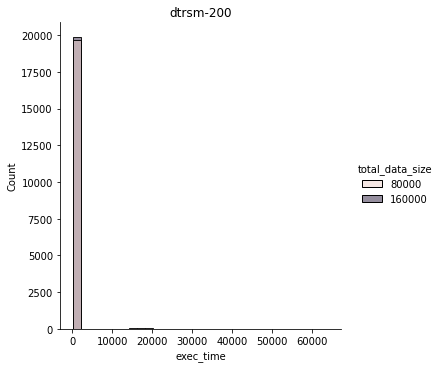

<Figure size 432x288 with 0 Axes>

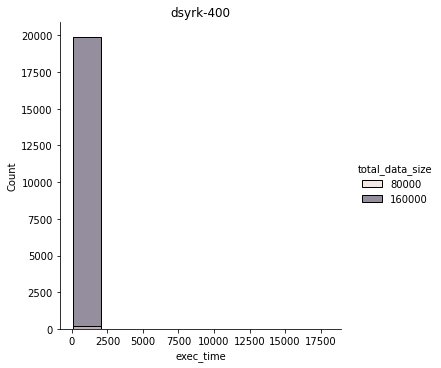

<Figure size 432x288 with 0 Axes>

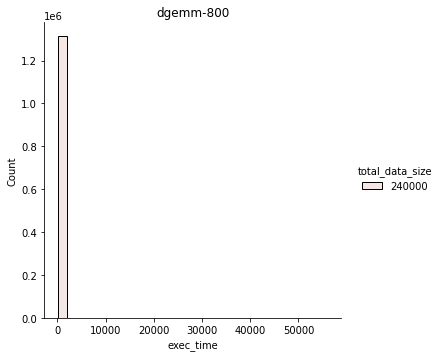

<Figure size 432x288 with 0 Axes>

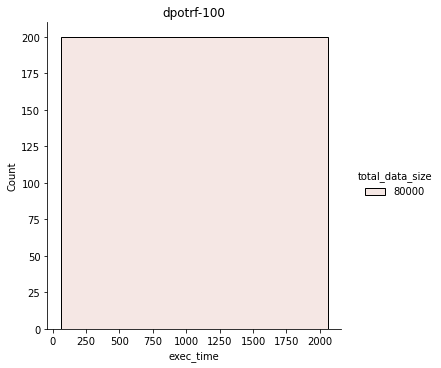

<Figure size 432x288 with 0 Axes>

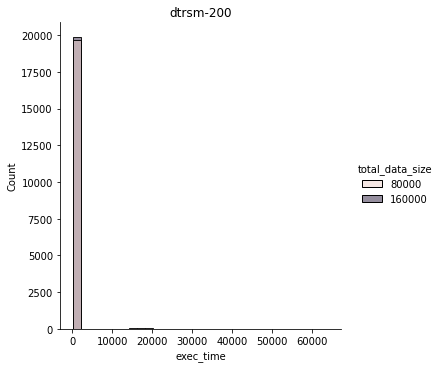

<Figure size 432x288 with 0 Axes>

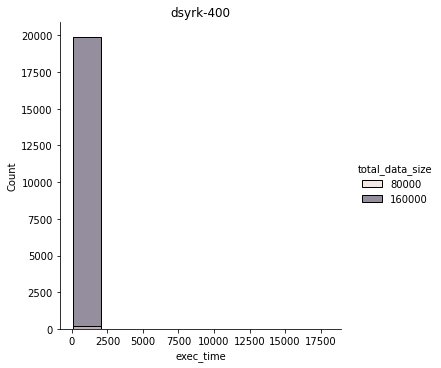

<Figure size 432x288 with 0 Axes>

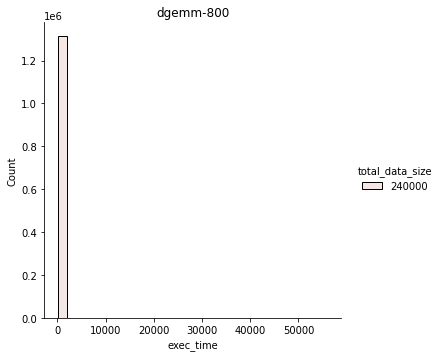

<Figure size 432x288 with 0 Axes>

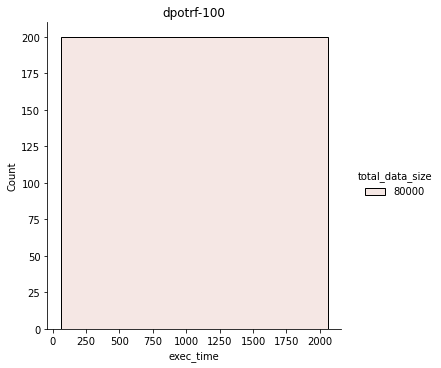

<Figure size 432x288 with 0 Axes>

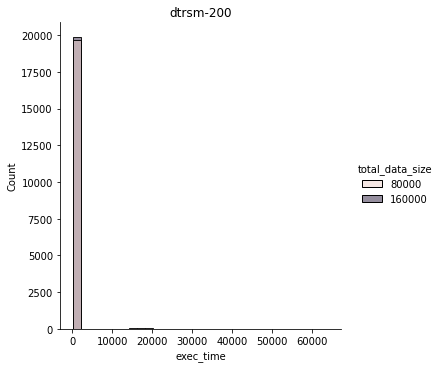

<Figure size 432x288 with 0 Axes>

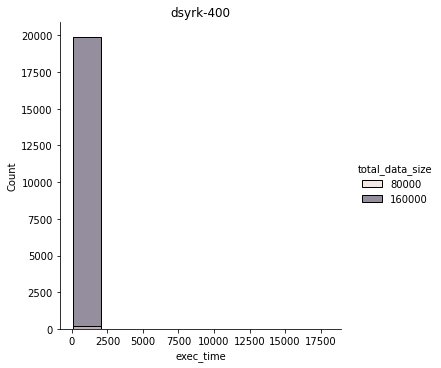

<Figure size 432x288 with 0 Axes>

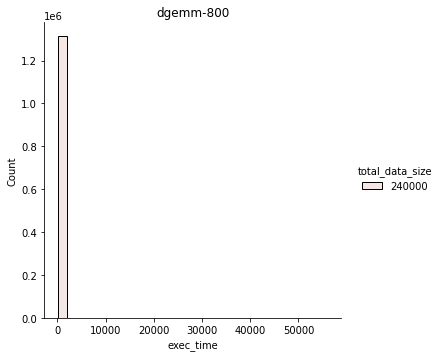

<Figure size 432x288 with 0 Axes>

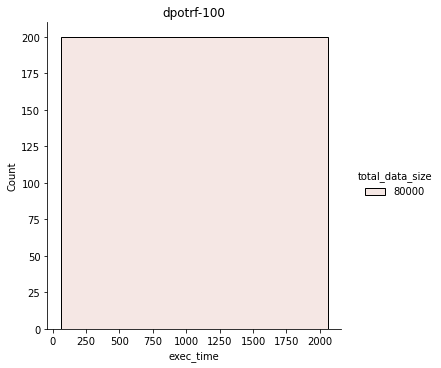

<Figure size 432x288 with 0 Axes>

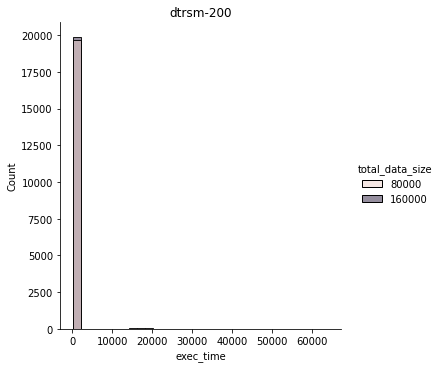

<Figure size 432x288 with 0 Axes>

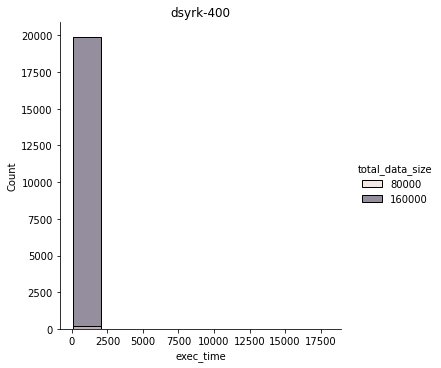

<Figure size 432x288 with 0 Axes>

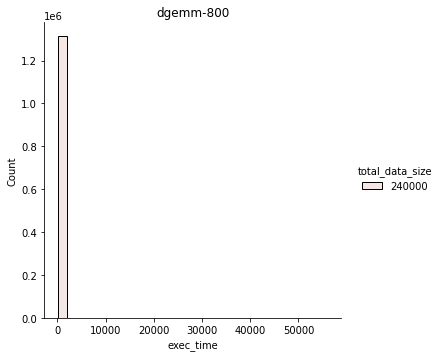

<Figure size 432x288 with 0 Axes>

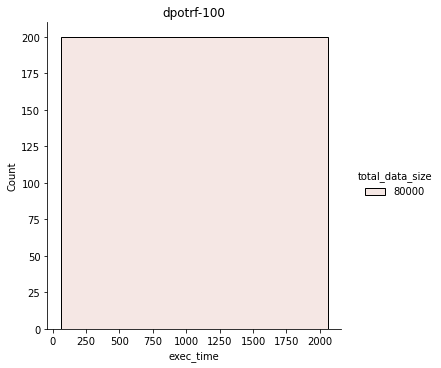

In [87]:
for i in range(0, len(li_refined)):
    for i in li_refined[0]['task_class_id'].unique():
        title = df_class_name[i] + str('-') + df_tile[i]
        data_plot = li_refined[0][li_refined[0]['task_class_id'] == i]
        plt.figure()
        #sns.displot(data_plot, x="exec_time", hue='total_data_size')
        sns.displot(data_plot, x="exec_time", hue='total_data_size', binwidth=2e3)
        plt.title(title)
        plt.savefig(title, dpi=300)
    plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/seab

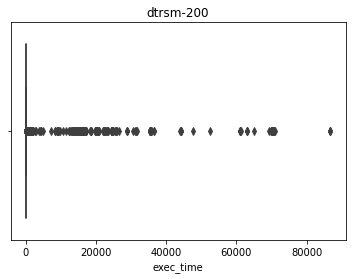

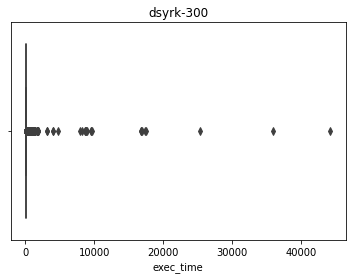

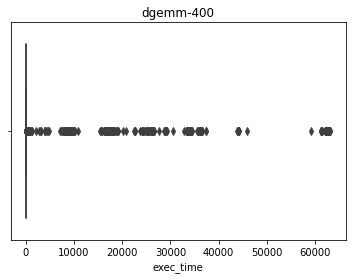

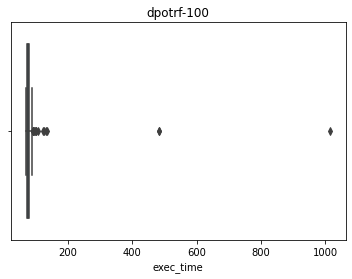

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/seab

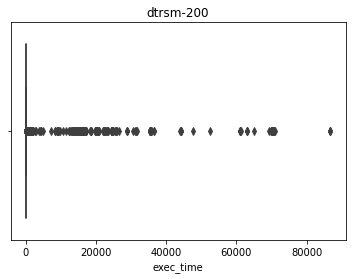

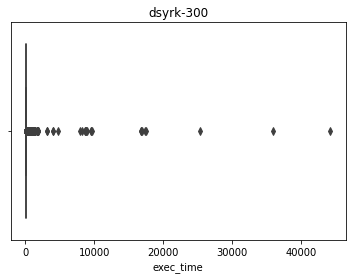

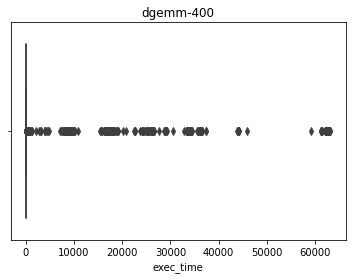

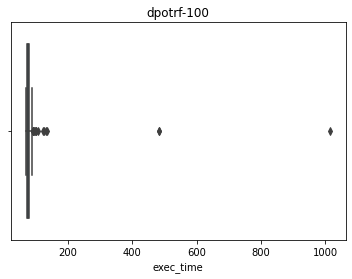

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/seab

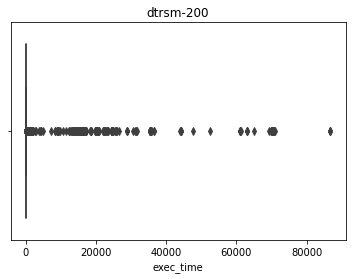

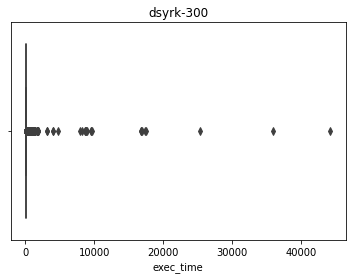

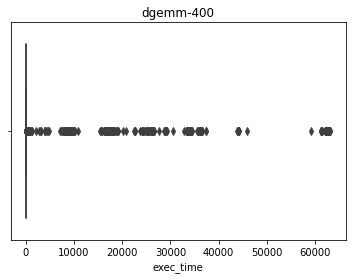

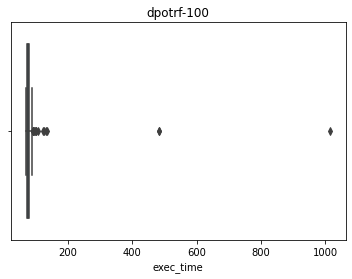

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/seab

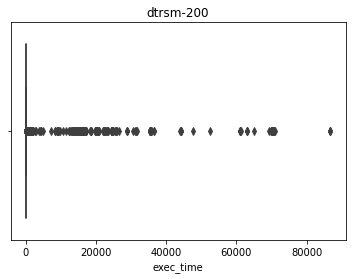

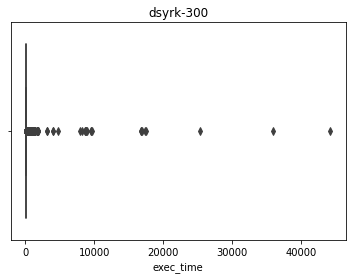

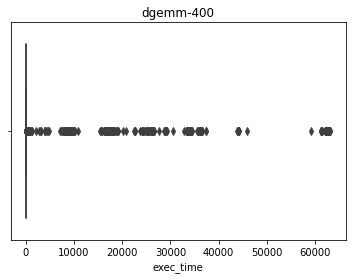

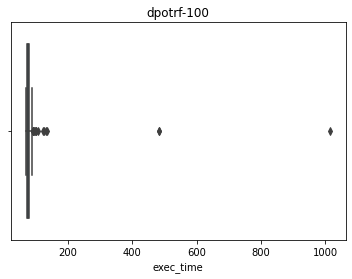

In [68]:

for i in range(0, len(li_refined)):
    for i in li_refined[0]['task_class_id'].unique():
        title = df_class_name[i] + str('-') + df_tile[i]
        data_plot = li_refined[0][li_refined[0]['task_class_id'] == i]
        plt.figure()
        sns.boxplot(data_plot['exec_time'])
        plt.title(title)
    plt.show()